# Bagging, SVM and ensemble learning
Authors: Adrian Naruszko & Tomasz Kanas

In this class we will introduce methods to combine and distribute multiple classifiers.

We will briefly look at those algorithms in PyTorch, then implement their distributed versions.

You can start by recovering your cloud setup by running the following commands, and proceed to the non-distributed tasks while they are running.

## Setup cloud environment

You will need the cloud environment we have created last week to complete this class. If you haven't done it yet, firstly finish [this](https://drive.google.com/file/d/1XKDSevaX6SnxbtxlQI5ZjP3dcMdy8HeH/view?usp=sharing) scenario.

To recover the environment you just have to run the following commands in the directory you placed the `simple_deployment.tf` file. Note that the execution may take several minutes.
```sh
. ./setup.sh
terraform apply
python parse-tf-state.py
ansible-playbook -i hosts install_packages.yml
ansible-playbook -i hosts config_ssh.yml
ansible-playbook -i hosts nfs.yml
```

To test the setup copy the master VM IP (the one printed by terraform) to the commands below and run them:

```
export GCP_IP=VM_ID
scp -i .ssh/id_gcp reduce.py $GCP_userID@$GCP_IP:~
ssh -i .ssh/id_gcp $GCP_userID@$GCP_IP "mpiexec --hostfile hostfile_mpi -x MASTER_ADDR=bml-0 -x MASTER_PORT=12340 -n 3 python3 reduce.py"
```

## Dataset setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.utils.data as data
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

For tests we will use some random points on a plane.

In [ ]:
# Create some synthetic 2D data

def init_synthetic_data(n_points=100, seed=42, distance=2):
  np.random.seed(seed)
  x_pos = np.random.randn(n_points, 2) + distance
  x_neg = np.random.randn(n_points, 2) - distance
  x_train = np.vstack([x_pos, x_neg])
  y_train = np.hstack([np.ones(n_points), -np.ones(n_points)])

  return x_train, y_train

# Support Vector Machines

## Hard-margin

The most basic formulation of SVM is to find a hyperplane separating two data classes that maximizes the margin between the classes. Such formulation can be expressed as a following optimization problem:

\begin{align}
  &\min_{w,b} ||w||^2 \\
  \text{subject to } &\forall_i y_i(w^Tx_i - b) \ge 1
\end{align}




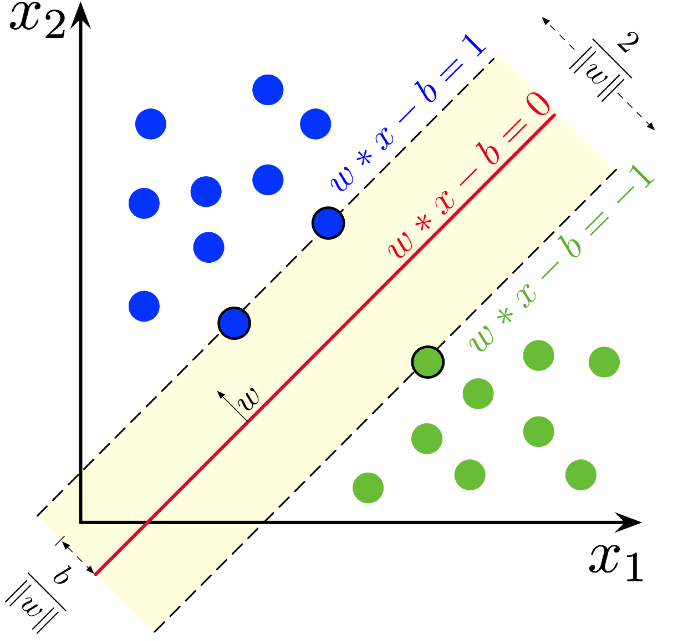

This is actually a quadratic optimization problem, so we can use existing solver to implement it. We will choose a simple one: `cvxopt`. From the [documentation](https://cvxopt.org/userguide/coneprog.html#quadratic-programming) we get the standard form we need to write our problem in.


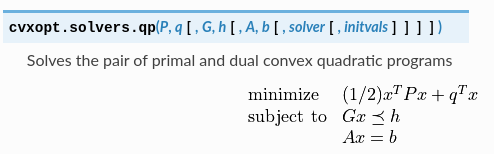

In [ ]:
import numpy as np
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas

def train_hard_svm(x, y):
  n, dims = x.shape
  # Identity matrix gives the sum of squares
  P = np.eye(dims + 1)
  P[dims, dims] = 0 # last dimension is the bias. 0 as it's not a part of the objective
  P = matrix(P)
  # No linear term in objective function
  q = matrix(np.zeros(dims + 1))
  # Each row in G is in the form: [-y[i] * x[i,1], -y[i] * x[i,2], y[i]] (last dimension is the bias)
  G = -y[:,None] * x
  G = np.hstack([G, y[:,None]])
  G = matrix(G)
  h = matrix(-1 * np.ones(n))

  res = qp(P, q, G, h)

  return np.array(res['x'][:dims]).flatten(), res['x'][dims], res['primal objective']

x_train, y_train = init_synthetic_data(distance=2)
w, b, loss = train_hard_svm(x_train, y_train)

print(f"w = {w}")
print(f"b = {b}")
print(f"loss = {loss}")

This part already indirectly involves parallelization, as most solvers will be able to parallelize the computation. Some solvers, like Gurobi for example, can even distribute the computation.

We can find the support vectors. If this is indeed the optimal solution, there should be exactly 3 support vectors.

In [ ]:
constr = np.matmul(-y_train[:,None] * x_train, w) + y_train * b + np.ones(x_train.shape[0])

support = np.where(constr > -1e-6)
print(f"Support vectors: {support}")
print(f"Support constraints: {constr[support]}")

Let's visualize the result. Below we define a visualization function that will be handy throught this scenario.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_svm(X, y, epoch, history):
    epoch_data = history[epoch]

    x_pos = X[y == 1]
    x_neg = X[y == -1]

    plt.figure(figsize=(8, 6))

    plt.scatter(x_pos[:, 0], x_pos[:, 1], color='b', label='Class A')
    plt.scatter(x_neg[:, 0], x_neg[:, 1], color='r', label='Class B')

    # Get lists of weights and biases
    w_list = epoch_data['w']
    b_list = epoch_data['b']

    x_vals = np.linspace(-5, 5, 100)

    for i, (w, b) in enumerate(zip(w_list, b_list)):
        if w[1] != 0:
            y_vals = -(w[0] * x_vals + b) / w[1]
            plt.plot(x_vals, y_vals, label=f'Decision boundary {i+1} (Epoch {epoch})')

            # Plot margins for the SVM
            y_margin_pos = -(w[0] * x_vals + b - 1) / w[1]
            y_margin_neg = -(w[0] * x_vals + b + 1) / w[1]
            plt.plot(x_vals, y_margin_pos, 'g--', label=f'Margin {i+1}')
            plt.plot(x_vals, y_margin_neg, 'g--')

    # Highlight points contributing to the loss (support vectors)
    for i in range(X.shape[0]):
        point = X[i].numpy()
        label = y[i].item()

        for w, b in zip(w_list, b_list):
            distance = label * (np.dot(point, w) + b)
            if distance < 1:  # Contributes to hinge loss
                plt.scatter(point[0], point[1], edgecolor='k', facecolor='none', s=100, linewidths=2)
            elif np.abs(distance - 1) < 1e-6:  # Support vector close to margin
                plt.scatter(point[0], point[1], edgecolor='y', facecolor='none', s=100, linewidths=2)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.title(f'Epoch {epoch} - Loss: {epoch_data["loss"]:.4f}')
    plt.legend()
    plt.grid(True)
    plt.show()


def merge_histories(histories):
    n_models = len(histories)
    n_epochs = len(histories[0])
    print(n_models, n_epochs)
    merged_history = []
    for epoch in range(n_epochs):
        epoch_data = {"w": [], "b": [], "loss": 0.0}

        total_loss = 0.0
        for history in histories:
            epoch_data["w"].append(history[epoch]["w"])
            epoch_data["b"].append(history[epoch]["b"])
            total_loss += history[epoch]["loss"]

        epoch_data["loss"] = total_loss / n_models
        merged_history.append(epoch_data)

    return merged_history


In [ ]:
history = [{
        'w': [w],
        'b': [-b], # usually bias is added not subtracted
        'loss': loss
    }]

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
plot_svm(x_train_tensor, y_train_tensor, 0, history)

### Dual approach

Optimization problems have also their *dual* versions that sometimes happen to be easier to solve, or have other beneficial properties. The **weak duality theorem** states, that every solution to a dual problem is a lower-bound to the optimal solution of the primal problem. For some problems (e.g. the one we are solving) there also holds the **strong duality** property, stating that the optimal solution to the dual problem is also the optimal solution to the primal problem. We will now use this property to solve the dual problem instead of the primal one.

For more information about the duailty in optimization you can start from this [Wikipedia](https://en.wikipedia.org/wiki/Duality_(optimization)) article. The derivation of the dual formulation is presented [here](https://kuleshov-group.github.io/aml-book/contents/lecture13-svm-dual.html).

The dual problem for SVM is:

\begin{align}
\max_c &\sum_{i=1}^n c_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n y_i c_i {\bf x_i \cdot x_j} c_j y_j \\
\text{subject to }& \sum_{i=1}^n c_i y_i = 0 \\
& \forall_i 0 \le c_i
\end{align}

Note, that $\bf{x_i \cdot x_j}$ is the scalar (dot) product of vectors.

### Excercise 1

Taking inspiration from the previous implementation, implement the dual problem using the `cvxopt.solvers.qp` solver.

TIP: The solver expects minimization problem, so to change our maximization problem to minimization, we need to multiply the objective by -1.

In [ ]:
def train_svm_dual(x, y):
  # TODO implement dual formulation
  pass

You are probably now wondering what can you do with the result of the dual problem. One can easily compute the primal solution from the dual one. The equations can be found e.g. [here](https://kuleshov-group.github.io/aml-book/contents/lecture13-svm-dual.html#obtaining-a-primal-solution-from-the-dual) (with a mistake in the equation for the bias - corrected below).

In [ ]:
c, loss = train_svm_dual(x_train, y_train)
x_neg = x_train[y_train == -1]
x_pos = x_train[y_train == 1]

w = np.sum(c[:,None] * y_train[:,None] * x_train, axis=0)
b = (np.max(np.matmul(x_neg, w)) + np.min(np.matmul(x_pos, w))) / 2

print(f"w = {w}")
print(f"b = {b}")
print(f"loss = {loss}")

If you did everything correctly, you should see the same values for `w` and `b`, and the `loss` value should be negated compared to the primal version.

### Geometry of SVM

The connection between primal and dual SVM formulations can be represented between connection between the separating hyperspace and the support vectors.

As you might have already noticed, the optimal SVM hyperplane in $d$ dimensional space will have exactly $d+1$ support vectors. Moreover the coefficients of the hyperplane can be computed from the support vectors (and vice versa).

The intuition behind the dual variables is that they are weights of the constraints of the primal program:

\begin{align}
  &\min_{w,b} ||w||^2 \\
  \text{subject to } &\forall_i y_i(w^Tx_i - b) \ge 1
\end{align}

If the constraint $1 - y_i(w^Tx_i - b)$ is not fulfilled, the (negative) value $c_i(1 - y_i(w^Tx_i - b))$ will be added to the dual objective. So in the optimal solution only for support vectors $c_i > 0$ (as then it doesn't decrease the dual). For more concrete reason why this is true, look at the [derivation](https://kuleshov-group.github.io/aml-book/contents/lecture13-svm-dual.html#the-dual-of-the-svm-problem) of the dual form.

So you can think about the dual problem, that it tries to find the support vectors instead of the hyperplane.

Let us test this observation now


In [ ]:
np.where(c > 1e-4)

### Performance comparision

Let us now compare the times of running both versions.

In [ ]:
import timeit

# Disable printing
options['show_progress'] = False

print("Primal version")
print(timeit.timeit(lambda: train_hard_svm(x_train, y_train), number=10))

print("Dual version")
print(timeit.timeit(lambda: train_svm_dual(x_train, y_train), number=10))

As you see, the computation of dual version takes much longer than primal version. So, is there any reason of using dual version.

Let's say, that we have $n$ data points in $d$ dimensional space. Then in the primal version we have matrix $d \times d$, while in dual version the matrix is $n \times n$. Moreover computing a single entry of the dual matrix takes $\mathcal{O}(d)$, although computing this coefficients can easily be parallelized, so this part of the cost is not as important.

Thus we see, that the decision between primal and dual formulation comes down to how many we have examples, versus how many dimensional they are. Thus duals are mostly used when working with very high-dimensional data, for example in text processing.

### Kernelization

Another reason to use dual is the [kernelization](https://en.wikipedia.org/wiki/Kernel_method). When we have data that is not linearily separable, we embed it into a space in which it will be linearily separable. Let's denote such embedding by $\phi$. Often, this embedding will be very high dimensional, thus increasing the cost of primal version drastically. On the other hand, it turns out that the structure of the dual problem allows us to compute embedded version very efficiently. Let's look at the objective function of the dual with the embedding:

\begin{align}
\max_c &\sum_{i=1}^n c_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n y_i c_i ( \phi(x_i) \cdot \phi(x_j)) c_j y_j
\end{align}

It depends only on the values of the scalar products of the embeddings. Actually, often computing such scalar product can be done much faster without even computing the embedding. For example consider the map of all the polynomials of degree at least 2 for 3 dimensional feature space (where $c$ is arbitrary constant):

\begin{align}
\phi(x) = \begin{bmatrix}
    x_1 x_1 \\
    x_1 x_2 \\
    x_1 x_3 \\
    x_2 x_1 \\
    x_2 x_1 \\
    x_2 x_2 \\
    x_3 x_3 \\
    x_3 x_1 \\
    x_3 x_2 \\
    x_3 x_3 \\
    \sqrt{2}cx_1 \\
    \sqrt{2}cx_2 \\
    \sqrt{2}cx_3 \\
    c
    \end{bmatrix}
\end{align}

Then the scalar product can be computed using the equation:

\begin{align}
k(x,z) = \phi(x) \cdot \phi(z) = (x \cdot z + c)^2
\end{align}

what is much faster than computing the scalar product of embeddings. For this reason we substitute the scalar product in the objective function for the *kernel* function $k(x,z) = \phi(x) \cdot \phi(z)$.

In general for the embedding of $d$ features to the space of polynomials of degree at least $p$ we use the *polynomial kernel*:
\begin{align}
k(x,z) = (x \cdot z + c)^p
\end{align}

The kernel trick becomes even more usefull when we realize, that there are some kernel functions, that correspond to the infinite-dimensional embedding space. The key example here is popularly used Radial Basis Function (RBF) kernel:
\begin{align}
k(x,z) = \exp(-\frac{||x - z||^2}{2\sigma^2})
\end{align}

Where $\sigma$ is a hyperparameter. The feature space of this kernel contains all polynomials. The derivation of this fact is in this [Wikipedia article](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).


#### Question:

Another popular kernel function is cosine similarity:
\begin{align}
k(x,z) = \frac{x \cdot z}{||x||||z||}
\end{align}

Can you find the embedding $\phi$ for which this is a scalar product $k(x,z) = \phi(x) \cdot \phi(z)$?

#### Question solution

$\phi(x) = \frac{x}{||x||}$

### Excercise 2

Let's now experiment a bit with kernel functions. Implement below an SVM with kernel function and the polynomial kernel defined above.

In [ ]:
def train_svm_dual(x, y, kernel=lambda x, z: np.dot(x, z)):
  # TODO: implement
  pass

def poly_kern(p=2, c=1):
  return lambda x,z: None # TODO: implement

Let's now generate some random linearly nonseparable data for experimenting.

In [ ]:
np.random.seed(42)
n = 200
# Draw data from uniform distribution on [0,1]^2
x_coeff = np.random.rand(n)
y_coeff = np.random.rand(n)
# Separate them by y=0.5
y_coeff[:n//2] += 1
y_coeff[n//2:] -= 1

x_sq = np.zeros((n,2))

# Simple quadratic mapping
def mapping(x,y):
  return x, y + 10 * x ** 2

x_sq[:,0], x_sq[:,1] = mapping(x_coeff, y_coeff)
y_sq = np.hstack([np.ones(n//2), -np.ones(n//2)])

# Plot transformed data
plt.figure(figsize=(8, 6))
plt.scatter(x_sq[:n//2, 0], x_sq[:n//2, 1], color='b', label='Class A')
plt.scatter(x_sq[n//2:, 0], x_sq[n//2:, 1], color='r', label='Class B')

plt.legend()
plt.grid(True)
plt.show()

But now we have problem, how to infer anything from the optimization solution, as generating the primal solution from dual makes little sense when using kernels. But we can avoid that. Let's recall the equations for the primal solution.

\begin{align}
w &= \sum_{i=1}^n c_iy_ix_i \\
b &= \frac{1}{2}(\max_{i:y_i = -1}(w \cdot x_i) + \min_{i:y_i = 1}(w \cdot x_i)) \\
\end{align}

Thus for a given vector $x'$ the inferred class is:

\begin{align}
y' = w \cdot x - b = \sum_{i=j}^n c_j y_j(x_j \cdot x') - b
\end{align}

By substituting the scalar products by the kernel function we get

\begin{align}
b &= \frac{1}{2}\left(\max_{i:y_i = -1}\left(\sum_{j=1}^n  c_j y_j k(x_j, x_i)\right) + \min_{i:y_i = 1}\left(\sum_{j=1}^n c_j y_j k(x_j, x_i)\right)\right) \\
y' &= \sum_{i=j}^n c_j y_j k(x_j, x') - b
\end{align}

This equation may seem costly to compute, but we can save quite some time, by computing the sums over only the support vectors, i.e. the ones for which $c_i > 0$.

Implement them below:

In [ ]:
def compute_b(x, y, c, kernel):
  # TODO implement
  pass

def predict(nx, x, y, c, b, kernel):
  # TODO implement
  pass

Let's now train the SVM and verify the correctness. We can do this for example by verifying that the primal constraints for the support vectors are tight, i.e. the dual prediction is for them close to $\pm 1$

In [ ]:
c, loss = train_svm_dual(x_sq, y_sq, kernel=poly_kern(2))
b = compute_b(x_sq, y_sq, c, poly_kern(2))
print(f"b = {b}")

support = np.where(c > 1e-4)
print(f"support vectors: {support[0]}")

print(f"Solution values for the support vectors: {(c * y_train)[c > 1e-4]}")
print(f"Predictions for support vectors (should be roughly +-1): {[predict(x_sq[s, :], x_sq, y_sq, c, b, poly_kern(2)) for s in support[0]]}")

If everything works, then we are ready to plot the results

In [ ]:
def plot_kernelized(x, y, kernel, y_min, y_max):
    c, loss = train_svm_dual(x, y, kernel)
    b = compute_b(x, y, c, kernel)
    x_min, x_max = 0, 1
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]

    mesh = np.stack([XX, YY], axis=-1)
    Z = np.array([[predict(nx, x, y, c, b, kernel) for nx in row] for row in mesh])

    plt.figure(figsize=(8, 6))

    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],levels=[-1, 0, 1])
    plt.scatter(x[:n//2, 0], x[:n//2, 1], color='b', label='Class A')
    plt.scatter(x[n//2:, 0], x[n//2:, 1], color='r', label='Class B')
    plt.scatter(x[c > 1e-4, 0], x[c > 1e-4, 1], edgecolor='green', facecolor='none', s=100, linewidths=2)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_kernelized(x_sq, y_sq, poly_kern(2), -1.5, 12)

Let's try one more scenario. Check out the dataset generated below.

In [ ]:
np.random.seed(42)
n = 400
# Draw data from uniform distribution on [0,1]^2
x_coeff = np.random.rand(n)
y_coeff = np.random.rand(n)
# Separate them by y=0.5
y_coeff[:n//2] += 1
y_coeff[n//2:] -= 1
x_sin = np.zeros((n,2))

# Simple quadratic mapping
def mapping(x,y):
  return x, y + np.sin(20 * x)

x_sin[:,0], x_sin[:,1] = mapping(x_coeff, y_coeff)
y_sin = np.hstack([np.ones(n//2), -np.ones(n//2)])

# Plot transformed data
plt.figure(figsize=(8, 6))
plt.scatter(x_sin[:n//2, 0], x_sin[:n//2, 1], color='b', label='Class A')
plt.scatter(x_sin[n//2:, 0], x_sin[n//2:, 1], color='r', label='Class B')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plot_kernelized(x_sin, y_sin, poly_kern(2), -2, 3)

Doesn't look good, isn't it? Let's try higer exponent then.

In [ ]:
plot_kernelized(x_sin, y_sin, poly_kern(4), -2, 3)

Its getting better, but still pretty bad. Probably increasing the exponent would make it, but if we would increase the number of bumps, then it will need larger and larger exponent. So let's try different kernel --- Radial Basis Function (RBF) kernel:
\begin{align}
k(x,z) = \exp(-\frac{||x - z||^2}{2\sigma^2})
\end{align}

Implement it below and run training!

In [ ]:
def rbf_kern(sigma=1):
  return lambda x,z: None # TODO implement

In [ ]:
plot_kernelized(x_sin, y_sin, rbf_kern(), -2, 3)

Not ideal, but much better! Try experimenting with different constants and see how they impact the result.

## Parallelization remarks

SVMs are powerfull algorithms, but one of their advantages is the ability to parallelize. Popular ML algorithms are quite difficult to optimize efficiently. Usually we can't do much more than distributed gradient descent. But for SVMs we have already seen 2 easy ways to distribute:
- Quadratic optimization solver --- usually has a built-in features that allow parallelizing, or even distributing in the better solvers.
- Parallelization of computing of the coefficients of the kernel matrix -- embarrasingly parallel.

But turns out, that you can find more ways to efficiently distribute this algorithm. For example in this NeurIPS paper:
https://papers.nips.cc/paper_files/paper/2004/hash/d756d3d2b9dac72449a6a6926534558a-Abstract.html

Idea is that the only datapoints that are relevant for an instance are the support vectors, the remaining datapoints can be removed without impacting the result. So we can build a binary tree (or other hierarhical structure) and every node trains (in parallel) SVM on a fraction of the data. Then node propagate the support vectors to their children and train SVM only on those. At the end the final support vectors are sent to the starting nodes, to make sure that they are indeed global optimum.

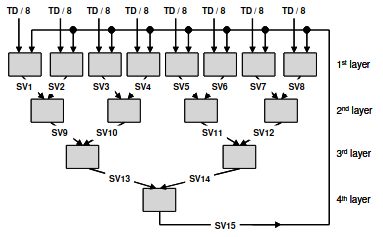

## Soft Margin Support Vector Machines
In our previous sections, we explored Hard SVM where we assumed our data was perfectly linearly separable (possibly after kernel transformation). However, this assumption rarely holds in real-world applications for two key reasons:

- Noise in Data: Real datasets often contain measurement errors, outliers, or inherent noise that can make perfect separation impossible or undesirable.
- Overfitting Risk: Even when perfect separation is possible, forcing the model to achieve it might lead to poor generalization, as the decision boundary becomes too sensitive to individual training points.

Let's take a set that cannot be separated and apply hard SVM methods:

In [ ]:
x_train, y_train = init_synthetic_data(distance=1)
w, b, loss = train_hard_svm(x_train, y_train)

history = [{
        'w': [w],
        'b': [-b],
        'loss': loss
    }]

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
plot_svm(x_train_tensor, y_train_tensor, 0, history)

This solution makes no sense. In order to handle such cases, we need to change our approach. Let's define the problem in ML terms and train our model!

A way to deal with the linearily nonseparable data is to allow for some outliers. This is called a *soft-margin* SVM and can be defined by extending the constrained optimization problem, by adding slack variables:

\begin{align}
  &\min_{w,b,\xi} \lambda||w||^2 + \sum_i \xi_i \\
  \text{subject to } &\forall_i y_i(w^Tx_i - b) \ge 1 - \xi_i \\
  & \forall_i \xi_i > 0
\end{align}

Where $\lambda$ is a hyperparameter, that controls how much it can divert from hard-margin version. As any constrained optimization problem, this one also has its dual version:

\begin{align}
\max_c &\sum_{i=1}^n c_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n y_i c_i {\bf x_i \cdot x_j} c_j y_j \\
\text{subject to }& \sum_{i=1}^n c_i y_i = 0 \\
& \forall_i 0 \le c_i \le \frac{1}{2n\lambda}
\end{align}

Do you see the difference with the hard-margin dual?

There is equivalent definition in terms of unconstrained optimization of the loss function described below.

### Excercise 3
In this exercise, your task is to implement SVM loss function with hinge loss and L2 regularization


#### Recap: SVM Loss Function
SVM penalises only the points that lie inside the margin. Thus the loss function should be:

$hinge\ loss=max(0,1−y⋅f(x))$

As you will note during experiments, that still leaves space for strange model behavior. Model may exploit the dataset and choose too narrow / too wide margin.
In order to prevent this we will introduce L2 regularization term to the loss.

$reg\ term=0.5 \cdot ∥w∥^2$

The final loss is then

$loss=C\cdot hinge\ loss+reg\ term$

where $C$ is our control parameter.

In [ ]:
class SVMLoss(nn.modules.Module):
    def __init__(self, C=1.0):
        super().__init__()
        self.C = C

    def forward(self, outputs, labels, weights):
         '''TODO Excercise 3'''

class LinearSVM(nn.Module):
    def __init__(self, size, C=1.0):
        super().__init__()
        self.fc = nn.Linear(size, 1)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        self.criterion = SVMLoss(C=C)

    def forward(self, x):
        return self.fc(x)

    def predict(self, X):
        with torch.no_grad():
            outputs = self.forward(X).squeeze(1)
            predictions = torch.sign(outputs)
            return predictions

    def fit(self, optimizer, X, y, epochs=10):
        history = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(X).squeeze(1)
            loss = self.criterion(outputs, y, self.fc.weight)
            loss.backward()
            optimizer.step()

            # Store weights, bias, and loss for visualization
            history.append({
                'w': [self.fc.weight.detach().numpy().flatten()],
                'b': [self.fc.bias.detach().item()],
                'loss': loss.item()
            })

        return history


def evaluate_model(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = model.predict(X_test)
        correct = (outputs == y_test).sum().item()
        total = y_test.size(0)

    accuracy = correct / total
    return accuracy

### Visualise soft SVM epoch by epoch
If you want to know in details how model and dataset parameters affect the training process, here is a nice animation that show this process epoch by epoch. Let's play with them for a while.

In [ ]:
!pip install ipywidgets

from google.colab import output
from ipywidgets import interact, Play, IntSlider, jslink
output.enable_custom_widget_manager()

def play(history, X, y, epochs):
  play = Play(
      value=0,
      min=0,
      max=epochs-1,
      step=1,
      interval=500,
      description="Press play",
      disabled=False
  )

  def plot_fun(epoch):
    plot_svm(X, y, epoch, history)

  slider = IntSlider(min=0, max=epochs-1, step=1, value=0)
  interact(plot_fun, epoch=slider)
  jslink((play, 'value'), (slider, 'value'))
  display(play, slider)

In [ ]:
model = LinearSVM(size=2, C=1)  # 2 for 2D data
optimizer = optim.SGD(model.parameters(), lr=0.03)
epochs = 100

X_train, y_train = init_synthetic_data(distance=1)
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

history = model.fit(optimizer, X=x_train_tensor, y=y_train_tensor, epochs=epochs)

play(history, x_train_tensor, y_train_tensor, epochs)

Is the suggested $C=1$ value a good choice? Can you come up with a better alternative? Discuss your findings

In the third excercise you may choose one of the two versions. First is about Bagging, second one about Cascade SVM. Both involve some work with the model logic and distribution.

## Excercise 4: Bagging
It's a common theme in ML that models ensemble perform better than each of its components.

One way to combine models is bagging.

Bagging works by:
- training independent models on dataset derived from the input dataset;
- combining predictions of those models to give its final verdict.

Models datasets are commonly made by sampling with replacement on the input dataset.

Your goal in this excercise is to
- A) implement sample bootstraping;
- B) implement distributed version of bagging.

In [ ]:
import torch
import numpy as np


class Bagging(torch.nn.Module):
    def __init__(self, base_model_factory, n_estimators=10, sample_size=1.0):
        super().__init__()
        self.base_model_factory = base_model_factory
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.models = torch.nn.ModuleList([self._initialize_model() for _ in range(n_estimators)])

    def _initialize_model(self):
        return self.base_model_factory()

    def forward(self, X):
        scores = []
        for model in self.models:
            score = model(X)
            scores.append(score)

        scores = torch.stack(scores)  # Shape: (n_estimators, n_samples)
        average_score = scores.mean(dim=0)

        # Convert the average score to class predictions (e.g., -1 or 1)
        predictions = torch.sign(average_score)
        return predictions

    def predict(self, X):
        predictions = []
        for model in self.models:
            preds = model.predict(X)
            predictions.append(preds)

        predictions = torch.stack(predictions)
        majority_preds = torch.mode(predictions, dim=0)[0]
        return majority_preds

    def fit(self, X, y, optimizer_class, epochs=100):
        histories = []
        for i, model in enumerate(self.models):
            X_sample, y_sample = self._bootstrap_sample(X, y, self.sample_size)
            optimizer = optimizer_class(model.parameters())
            single_history = model.fit(optimizer, X=X_sample, y=y_sample, epochs=epochs)
            histories.append(single_history)

        return merge_histories(histories)

    def _bootstrap_sample(self, X, y, sample_size):
        '''TODO Excercise 4a
        X, y - input dataset
        sample_size - the franction of the dataset to use for bootstrapping
        '''


In order to observe Bagging superiority over single SVM model let's look at the following dataset:

In [ ]:
import numpy as np
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=200, noise=0.1, factor=0.2, random_state=42)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_circle = torch.tensor(X_train, dtype=torch.float32)
y_train_circle = torch.tensor(y_train, dtype=torch.float32)
X_test_circle = torch.tensor(X_test, dtype=torch.float32)
y_test_circle = torch.tensor(y_test, dtype=torch.float32)


def plot_dataset(X, y, title="Circles Dataset"):
    plt.figure(figsize=(8, 6))

    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class A')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class B')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_dataset(X_train, y_train)

Single linear SVM cannot distinguish between those classes with enough effectivenes. Kernelelization may come in handy, but this time we will focus on Bagging. As each model is trained on a different subset of data, they effectively capture the boundary from different perspectives.

In [ ]:
import random
model_fun = lambda: LinearSVM(size=2, C=100)
optimizer_fun = lambda params: optim.SGD(params, lr=0.03)

epochs = 100
single_model = model_fun()
single_optimizer = optimizer_fun(single_model.parameters())
bagging_svm = Bagging(model_fun, n_estimators=20, sample_size=0.1)

history_bagging = bagging_svm.fit(X_train_circle, y_train_circle, optimizer_fun, epochs=epochs)
history_single = single_model.fit(single_optimizer, X=X_train_circle, y=y_train_circle, epochs=epochs)

svm_accuracy = evaluate_model(single_model, X_test_circle, y_test_circle)
bagging_svm_accuracy = evaluate_model(bagging_svm, X_test_circle, y_test_circle)

# Plot all of the margins of bagging ensemble.
# Only for the brave ones!
# plot_svm(X_train_circle, y_train_circle, epochs-1, history_bagging)

print(f"LinearSVM Accuracy: {svm_accuracy * 100:.2f}%")
print(f"Bagging SVM Accuracy: {bagging_svm_accuracy * 100:.2f}%")

### Excercise 4b: If your sampling method works, its time to make it parallel with torch.dist!

In [ ]:
# Put your implementation here
# Hint: Start with extending the sequential version

### Optional Excercise

Implement Cascade SVM (sequential implementation is fine). The algorithm was described in [Parallelization remarks](https://colab.research.google.com/drive/1nZ85_3vEtfuD2VkoDGoxPyPqjeTyvDq0#scrollTo=GIKnoGTKiY4Z). The full definition is in https://papers.nips.cc/paper_files/paper/2004/hash/d756d3d2b9dac72449a6a6926534558a-Abstract.html.

You can use any SVM formulation for the Cascade.